# Visualizing dyad

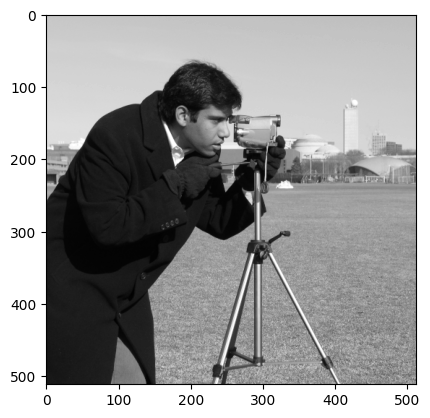

In [1]:
# load an image from skimage.data

import skimage
import matplotlib.pyplot as plt

img = skimage.data.camera()

plt.imshow(img, cmap='gray')
plt.show()

In [2]:
# compute the image SVD decomposition

import numpy as np

U, s, VT = np.linalg.svd(img, full_matrices=True)

# the full S matrix
m, n = img.shape
S = np.zeros((m, n))
S[:n, :n] = np.diag(s)

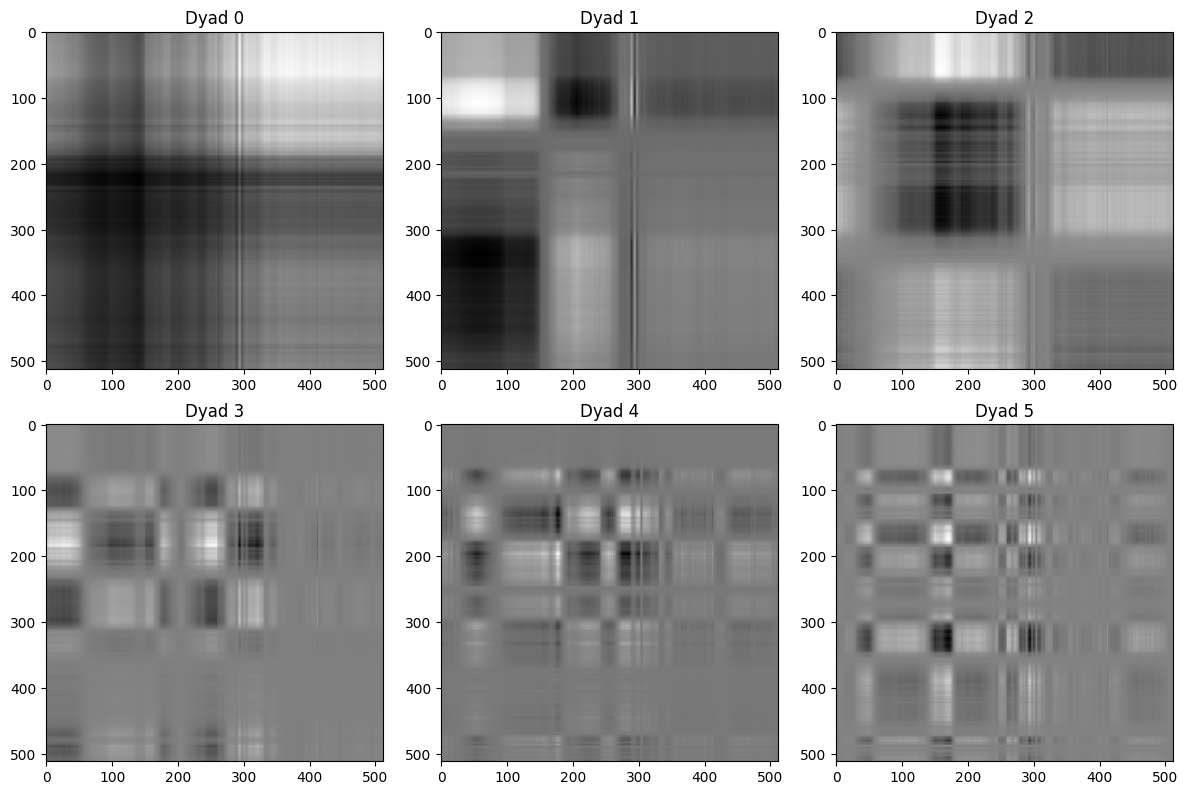

In [3]:
# visualize some of the dyads
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    # first dyad
    dyad = U[:, i].reshape(m, 1) @ VT[i, :].reshape(1, n)
    plt.imshow(dyad, cmap='gray')
    plt.title(f'Dyad {i}')

plt.tight_layout()
plt.show()

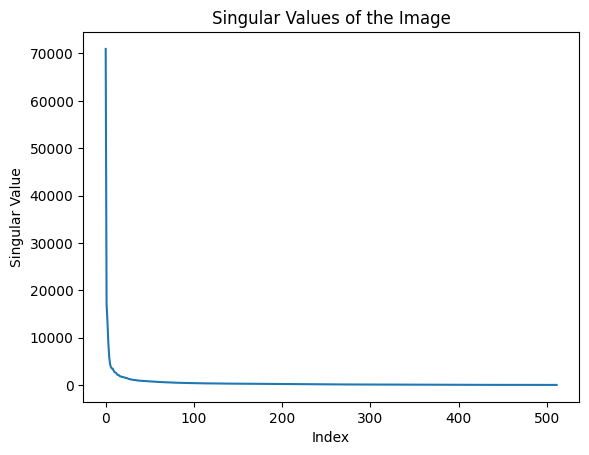

In [4]:
# plot the singular values of the image

plt.plot(s)
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of the Image')
plt.show()

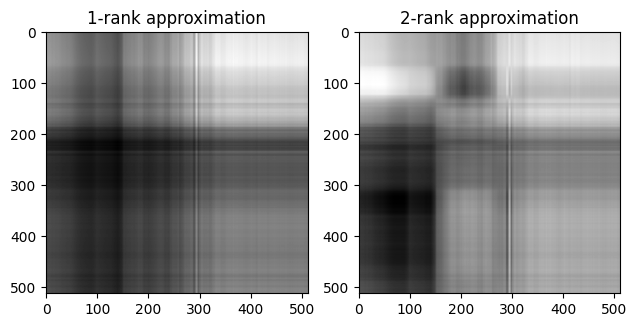

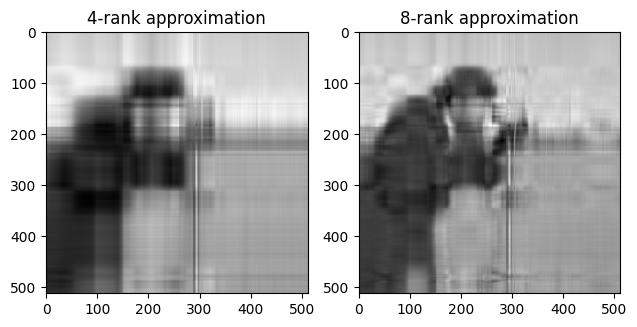

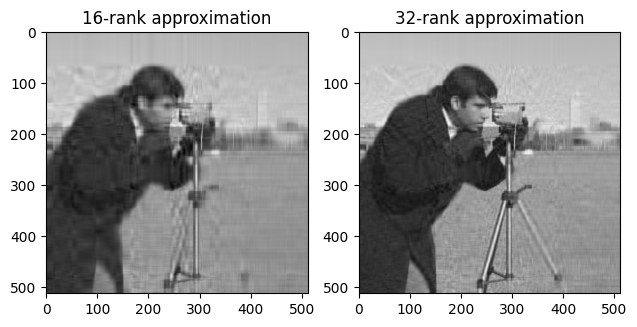

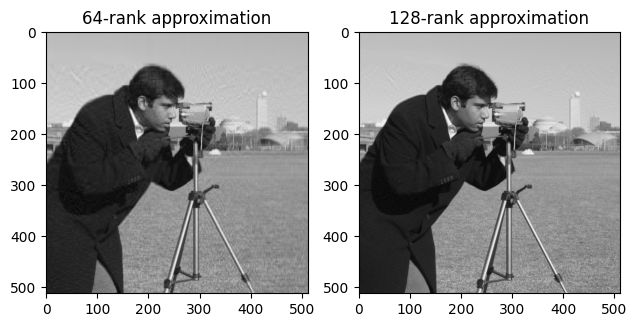

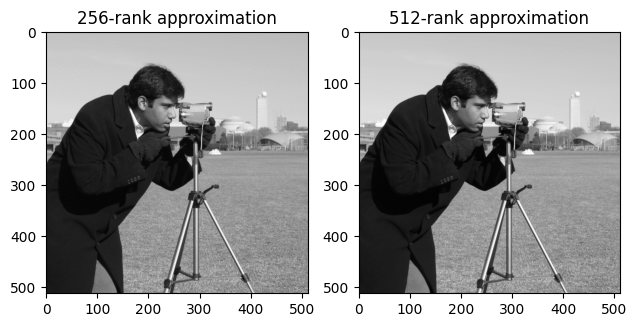

In [5]:
# visualize some k-rank approximations

def krank_approx(k):
    return U[:, :k] @ S[:k, :k] @ VT[:k, :]

approximations = [(k, krank_approx(k)) for k in np.logspace(0, 9, 10, base=2, dtype=int)]
for ak_enum in enumerate(approximations):
    plt.subplot(1, 2, ak_enum[0] % 2 + 1)
    plt.imshow(ak_enum[1][1], cmap='gray')
    plt.title(f'{ak_enum[1][0]}-rank approximation')

    # show images in couples
    if ak_enum[0] % 2 == 1:
        plt.tight_layout()
        plt.show()

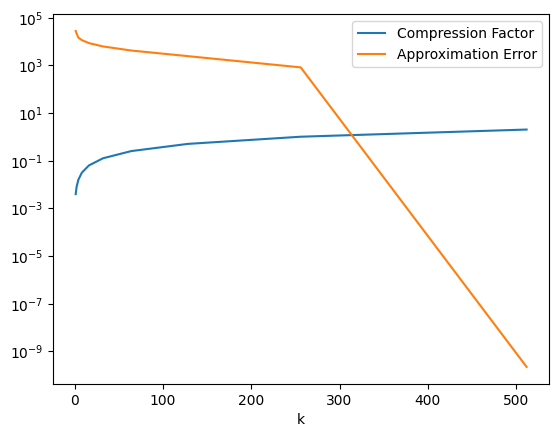

In [21]:
# compute and plot the approximation error for different values of k
approx_error = [(el[0], np.linalg.norm(img - el[1], 'fro')) 
                for el in approximations]

# compute and plot the compression factor ck
ck = [appr[0] * (m + n + 1) / (m * n) for appr in approximations]

plt.plot([el[0] for el in approximations], ck, label='Compression Factor')
plt.xlabel('Compression Factor')

plt.plot([el[0] for el in approx_error], [el[1] for el in approx_error], label='Approximation Error')
plt.xlabel('k')

plt.yscale('log')
plt.legend()
plt.show()

# Classification of MNIST Digits with SVD Decomposition

In [7]:
# load the dataset
import scipy

mnist = scipy.io.loadmat('MNIST.mat')
X = mnist['X']
I = mnist['I']
print(X.shape, I.shape)

(256, 1707) (1, 1707)


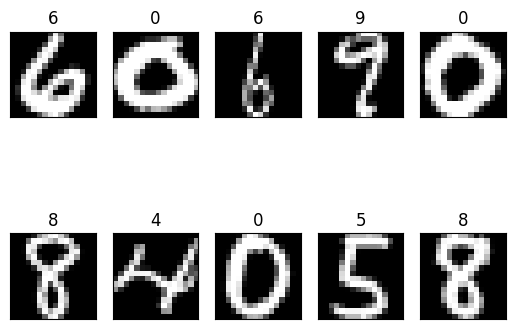

In [8]:
# show some of the datapoints

for i in enumerate(np.linspace(0, X.shape[1] - 1, 10, dtype=int)):
    plt.subplot(2, 5, i[0]+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[:, i[1]].reshape(16, 16), cmap='gray')
    plt.title(I[0, i[1]])

In [9]:
# extract the columns corresponding to the two digits
digit1 = 6
digit2 = 8

I_1_2 = [i for i, el in enumerate(I[0]) if el in { digit1, digit2 }]
X_1_2 = X[:, I_1_2]

In [10]:
# split the dataset into training and test sets

training_set_length = int(X_1_2.shape[1] // 1.1)
training_set = X_1_2[:, :training_set_length]
training_set_labels = I[:, I_1_2][:, :training_set_length]
test_set = X_1_2[:, training_set_length:]
test_set_labels = I[:, I_1_2][:, training_set_length:]

i_1 = [i for i, el in enumerate(training_set_labels[0]) if el == 3]
i_2 = [i for i, el in enumerate(training_set_labels[0]) if el == 4]

X1 = training_set[:, i_1]
X2 = training_set[:, i_2]

In [11]:
# compute the SVD decomposition of X3 and X4
U1, S1, VT1 = np.linalg.svd(X1, full_matrices=True)
U2, S2, VT2 = np.linalg.svd(X2, full_matrices=True)

In [12]:
# take an unknown digit from the test set and search in which space it lies

def test(y):
    y1_orth = U1 @ U1.T @ y
    y2_orth = U2 @ U2.T @ y

    # compute the distances between d3 and d4
    d1 = np.linalg.norm(y - y1_orth, 2)
    d2 = np.linalg.norm(y - y2_orth, 2)

    if d1 < d2:
        return digit1

    return digit2

In [13]:
results = []
for i in range(0, test_set.shape[1]):
    idx = np.random.randint(0, test_set.shape[1])
    y = test_set[:, i]
    y_true = test_set_labels[:, i]

    digit = test(y)
    results.append((digit, y_true[0]))

# filter elements of results where el[0] != el[1]
misclassification_err = len([el for el in results if el[0] != el[1]]) / len(results)
print(misclassification_err)

0.5185185185185185
